import

In [6]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [7]:
class_names = ['Dent', 'Other', 'Rim', 'Scratch']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (236,255)

loading the data

In [8]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['splitted_folder/train', 'splitted_folder/val']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [9]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading splitted_folder/train


100%|██████████| 224/224 [00:00<00:00, 484.92it/s]


Loading splitted_folder/val


100%|██████████| 56/56 [00:00<00:00, 618.42it/s]


In [10]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

explore the dataset

In [11]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 717
Number of testing examples: 180
Each image is of size: (236, 255)


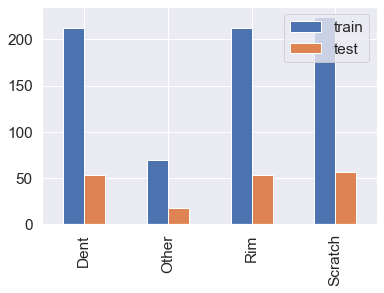

In [12]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

scale the data

In [13]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

visualize the data

In [14]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

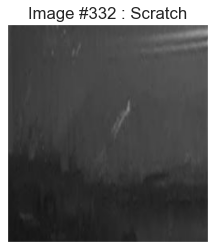

In [15]:
display_random_image(class_names, train_images, train_labels)

In [16]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

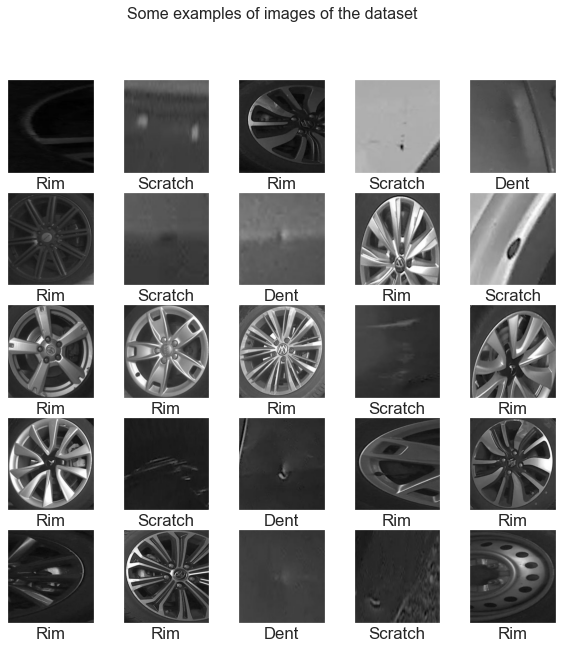

In [17]:
display_examples(class_names, train_images, train_labels)

VGG

In [18]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [19]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [24]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (15, 14, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [25]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15, 14, 512)]     0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 64)          294976    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0   

In [39]:
history = new_model.fit(train_features, train_labels, batch_size=256, epochs=50, validation_split = 0.2)

Epoch 1/50
3/3 [==============================] - 39s 11s/step - loss: 0.0516 - accuracy: 0.9878 - val_loss: 1.8654 - val_accuracy: 0.7847
Epoch 2/50
3/3 [==============================] - 39s 11s/step - loss: 0.0661 - accuracy: 0.9773 - val_loss: 1.8638 - val_accuracy: 0.7639
Epoch 3/50
3/3 [==============================] - 38s 11s/step - loss: 0.0660 - accuracy: 0.9791 - val_loss: 1.9535 - val_accuracy: 0.7778
Epoch 4/50
3/3 [==============================] - 38s 11s/step - loss: 0.0490 - accuracy: 0.9843 - val_loss: 2.0259 - val_accuracy: 0.7639
Epoch 5/50
3/3 [==============================] - 38s 12s/step - loss: 0.0428 - accuracy: 0.9825 - val_loss: 2.0738 - val_accuracy: 0.7500
Epoch 6/50
3/3 [==============================] - 37s 11s/step - loss: 0.0352 - accuracy: 0.9930 - val_loss: 2.1924 - val_accuracy: 0.7708
Epoch 7/50
3/3 [==============================] - 39s 11s/step - loss: 0.0334 - accuracy: 0.9930 - val_loss: 2.2263 - val_accuracy: 0.7500
Epoch 8/50
3/3 [===========

In [40]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

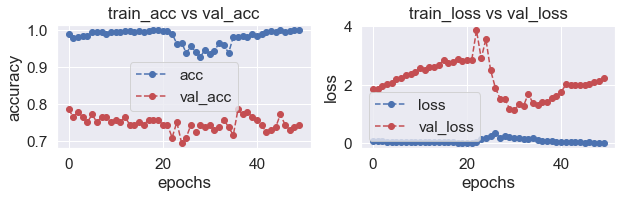

In [41]:
plot_accuracy_loss(history)

In [42]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.7722222222222223
